In [1]:
import causalgraphicalmodels as cgm
import matplotlib.pyplot as plt
import networkx as nx


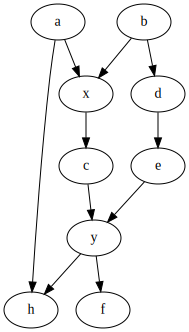

In [4]:
eg = cgm.examples.big_csm
eg.cgm.draw()

In [6]:
eg.sample(10)

,a,b,x,d,c,e,y,f,h
0,1.116578,0.143384,0,-0.717954,-0.108498,-0.893364,-0.909067,-1.858768,2.377696
1,-1.113879,0.547676,1,2.551964,1.460732,4.459260,-1.365851,-2.735423,-5.619632
2,-0.497302,0.111179,1,-0.483186,0.885838,0.973897,1.343044,2.490181,-0.043923
3,-0.852867,-1.327568,0,2.663075,1.348461,6.651865,-3.820900,-2.724530,-7.277658
4,0.097019,-0.939435,0,0.781928,-1.058824,1.144475,-3.379780,-2.790438,-4.226156
5,-0.291272,1.355587,1,-2.231471,1.611295,-4.541758,10.129347,6.872247,12.145273
6,-2.468398,-0.720631,1,0.335446,1.863162,2.102494,6.360336,6.124917,4.564703
7,0.387670,-0.157935,1,-0.467785,1.978538,-0.673895,6.115284,5.772473,9.342129
8,-0.361792,-0.703556,0,1.102819,0.793053,1.871503,1.127661,0.517830,0.335952
9,-0.464284,-0.223479,0,-0.323945,1.320867,-0.038868,5.194738,2.668400,5.557664


In [7]:
eg.do('x')

StructuralCausalModel(a, b, c, d, e, f, h, x, y)

In [9]:
eg.sample(100)['x'].mean()

0.49

In [7]:

from causalgraphicalmodels import StructuralCausalModel
import numpy as np

scm = StructuralCausalModel({
    "x1": lambda     n_samples: np.random.binomial(n=1,p=0.7,size=n_samples),
    "x2": lambda x1, n_samples: np.random.normal(loc=x1, scale=0.1),
    "x3": lambda x2, n_samples: x2 ** 2,
    "x4": lambda x1, x2, n_samples: x1 + x2
})


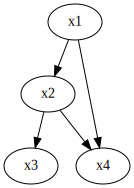

In [8]:
scm.cgm.draw()

In [10]:
scm.sample(5)

,x1,x2,x3,x4
0,1,1.169568,1.367889,2.169568
1,0,-0.163205,0.026636,-0.163205
2,1,0.959571,0.920777,1.959571
3,1,0.934697,0.873658,1.934697
4,0,-0.086521,0.007486,-0.086521


In [42]:
import torch
from torch import Tensor
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import dense_to_sparse


def adj_mat_from_scm(scm: StructuralCausalModel) -> Tensor:
    dag = scm.cgm.dag
    adj_mat = nx.adjacency_matrix(dag).todense()
    edge_index = dense_to_sparse(torch.tensor(adj_mat))
    return edge_index


def scm_to_dataset(scm: StructuralCausalModel, n_samp: int, batch_size: int) -> Data:
    df = scm.sample(n_samp)
    n_nodes = len(df.columns)
    data_vec = torch.tensor(df.values).flatten().unsqueeze(0).T

    # Need to get the DAG
    dag = adj_mat_from_scm(scm)
    data = []

    assert len(data_vec) % n_nodes == 0
    for i in range(0, len(data_vec) // n_nodes, n_nodes):
        data.append(Data(x=data_vec[i:(i+n_nodes)], edge_index=dag))

    return DataLoader(data, batch_size=batch_size)


In [43]:
import networkx as nx 
from torch_geometric.utils import dense_to_sparse

dense_to_sparse(torch.tensor(nx.adjacency_matrix(scm.cgm.dag).todense()))

(tensor([[0, 0, 1, 1],
         [1, 3, 2, 3]]),
 tensor([1, 1, 1, 1]))

In [56]:
from torch_geometric.utils import to_dense_adj

for item in scm_to_dataset(scm, 30, 10):
    print(item.x)
    print(item.edge_index[0])

tensor([1.], dtype=torch.float64)
tensor([[ 0,  0,  1,  1,  4,  4,  5,  5,  8,  8,  9,  9, 12, 12, 13, 13, 16, 16,
         17, 17, 20, 20, 21, 21, 24, 24, 25, 25, 28, 28, 29, 29],
        [ 1,  3,  2,  3,  5,  7,  6,  7,  9, 11, 10, 11, 13, 15, 14, 15, 17, 19,
         18, 19, 21, 23, 22, 23, 25, 27, 26, 27, 29, 31, 30, 31]])
